In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as kb
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
def drawGraph(validDataset, model, history_trainLoss, history_validLoss, history_trainLossStd, point):
    fig, ax = plt.subplots(3, figsize=(18,20))

    ax[0].set_title('Loss')
    x = np.arange(len(history_trainLoss))
    ax[0].plot(x, history_trainLoss, 'r-', label = 'history_trainLoss')
    ax[0].plot(x, history_validLoss, 'b-', label = 'history_validLoss')

    ax[1].set_title('Loss_std')
    x = np.arange(len(history_trainLossStd))
    ax[1].plot(x, history_trainLossStd, 'r-', label = 'history_trainLossStd')

    for p in point:
        ax[0].axvline(x = p, label='x = {}'.format(p), c='k')
        ax[1].axvline(x = p, label='x = {}'.format(p), c='k')

    for input__, output__ in validDataset:
        predicts = model(input__)
        index = tf.argmax(predicts, axis=1)

        for idx in range(input__.shape[0]):
            point = input__.numpy()[idx]
            answer = index.numpy()[idx]
            if answer == 0:
                ax[2].scatter(point[0], point[1], c='r')
            elif answer == 1:
                ax[2].scatter(point[0], point[1], c='b')
            elif answer == 2:
                ax[2].scatter(point[0], point[1], c='g')
            elif answer == 3:
                ax[2].scatter(point[0], point[1], c='k')
            elif answer == 4:
                ax[2].scatter(point[0], point[1], c='c')

    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    plt.show()
    #plt.savefig('validResult.png')    

In [3]:
def DataGenerator(center, length, numberOfdata):
    
    fig = plt.figure()
    
    # inputs
    tmp = tf.random.uniform([numberOfdata, 2], maxval = length)
    a = tf.constant([[center[0] - length/2.0, center[1] - length/2.0]])
    b = tf.constant([numberOfdata,1])
    bias = tf.tile(a, b)
    inputs = tf.data.Dataset.from_tensor_slices(tf.add(tmp, bias))
    # outputs
    outputs_ = np.zeros([numberOfdata])
    
    for idx, elem in enumerate(inputs):
        if abs(elem[0] - center[0]) < length/4.0 and abs(elem[1] - center[1]) < length/4.0:
            plt.scatter(elem[0], elem[1], c='c')
            outputs_[idx] = 4
        elif elem[0] > center[0] and elem[1] > center[1]:
            plt.scatter(elem[0], elem[1], c='r')
            outputs_[idx] = 0
        elif elem[0] > center[0]:
            plt.scatter(elem[0], elem[1], c='b')
            outputs_[idx] = 1
        elif elem[0] <= center[0] and elem[1] <= center[1]:
            plt.scatter(elem[0], elem[1], c='g')
            outputs_[idx] = 2
        elif elem[0] <= center[0]:
            plt.scatter(elem[0], elem[1], c='k')
            outputs_[idx] = 3
            
    outputs = tf.data.Dataset.from_tensor_slices(outputs_)
    
    
    fig.tight_layout()
    plt.savefig('trainDataset.png')
    plt.show()
    
    dataset = tf.data.Dataset.zip((inputs, outputs))
    return dataset
    
    #tmp = tf.fill([numberOfdata, 2], [1,2])
    #print(tmp)

"""
dataset_origin = DataGenerator([1, 0], 2, 1000)
dataset_batched = dataset_origin.shuffle(1000, reshuffle_each_iteration=True)

#numberOfData = dataset_batched.cardinality().numpy()
trainDataset = dataset_batched.take(int(numberOfData * 0.3))
validDataset = dataset_batched.skip(int(numberOfData * 0.3))
"""

'\ndataset_origin = DataGenerator([1, 0], 2, 1000)\ndataset_batched = dataset_origin.shuffle(1000, reshuffle_each_iteration=True)\n\n#numberOfData = dataset_batched.cardinality().numpy()\ntrainDataset = dataset_batched.take(int(numberOfData * 0.3))\nvalidDataset = dataset_batched.skip(int(numberOfData * 0.3))\n'

In [4]:
## Custom Modeling

class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        tmp = tf.matmul(inputs, self.w) + self.b
        #return kb.relu(tmp)
        return tmp * kb.sigmoid(tmp)
    

class CustomModel(keras.Model):
    def __init__(self, list_units):
        super(CustomModel, self).__init__()
        
        self.layers_custom = self.create_layers(list_units)
        
        self.layerLast = Linear(5)
        
    def create_layers(self, list_units):
        layers = []
        for units in list_units:
            layers.append(Linear(units))
        return layers
    
    def call(self, x):
        for layer in self.layers_custom:
            x = layer(x)
        x = self.layerLast(x)
        return kb.softmax(x)
    
def CustomLosses(true, predict):
    loss = true * kb.log(predict)
    loss_ = -tf.reduce_mean(loss, 1)
    loss_mean = tf.reduce_mean(loss_)
    loss_std = tf.math.reduce_std(loss_)
    return loss_mean, loss_std

epoch: 533   learning rate: 4
Time taken: 0.05s, Training acc over epoch: 0.9333
Time taken: 0.09s, Validation loss: 0.1687
Early Stopped !


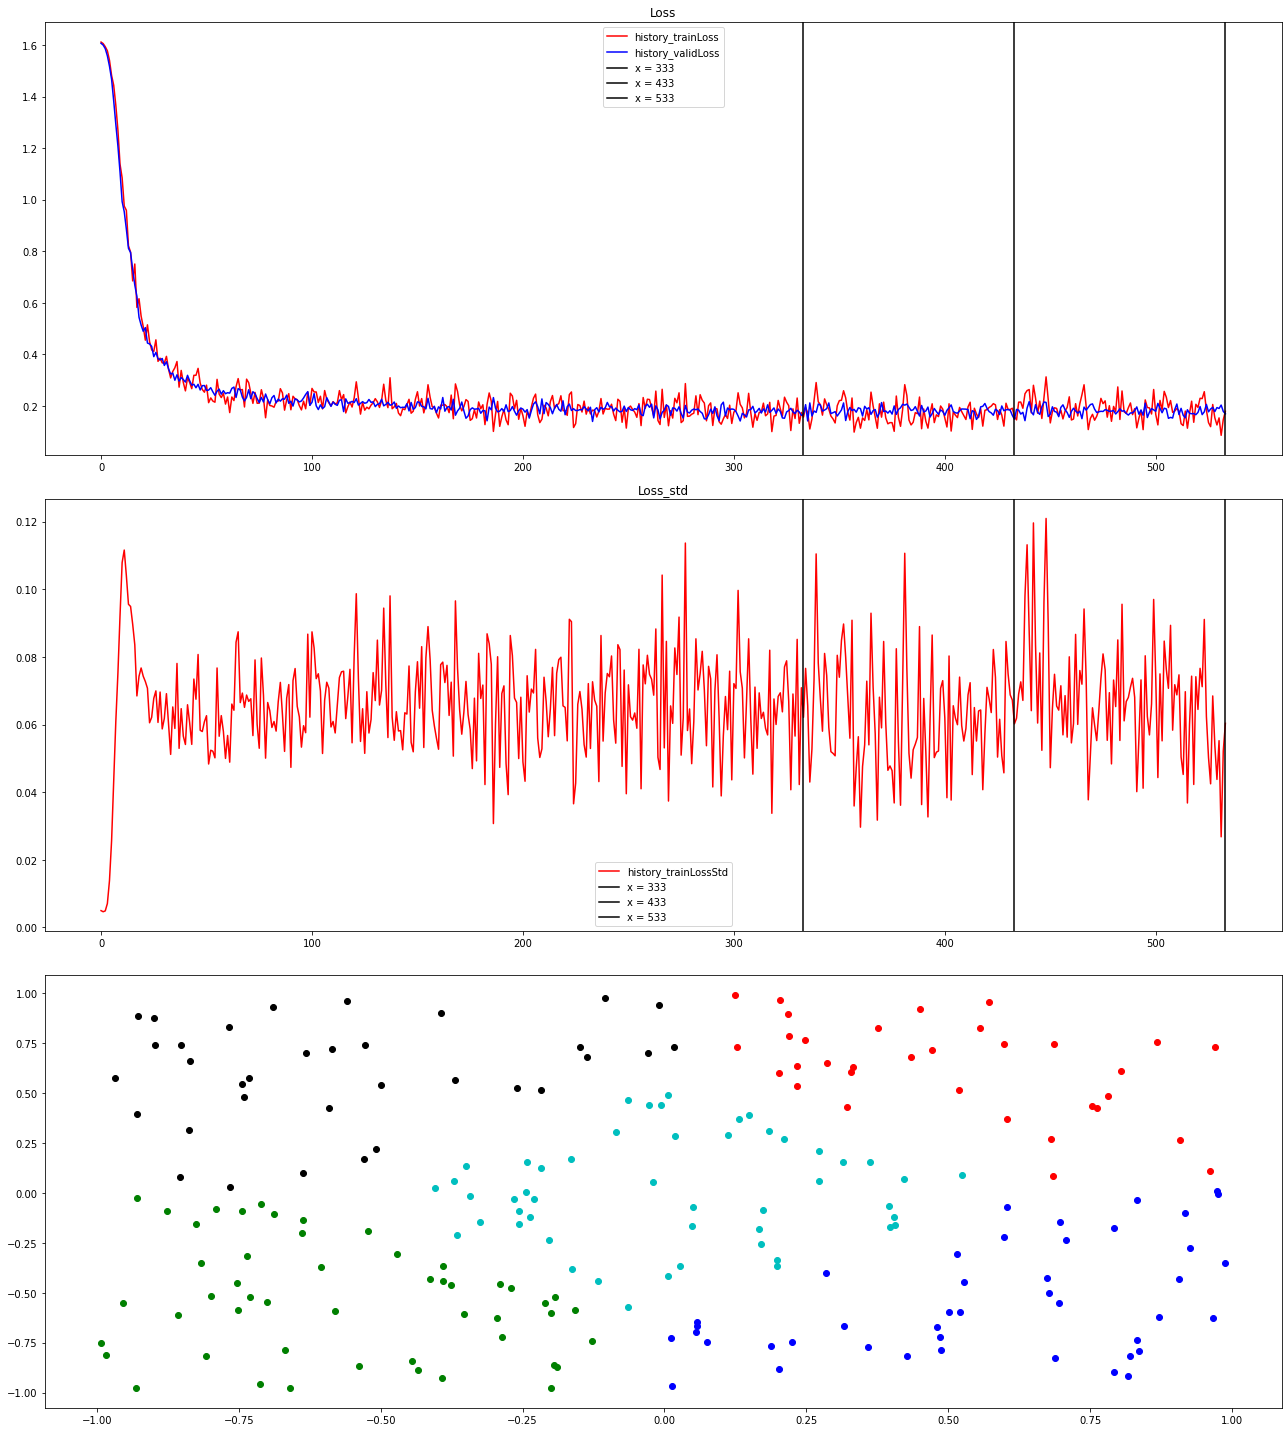

In [11]:
dataset_origin = DataGenerator([0, 0], 2, 300)
dataset_batched = dataset_origin.shuffle(300, reshuffle_each_iteration=True).batch(10, drop_remainder=True)
numberOfData = dataset_batched.cardinality().numpy()
#numberOfData = dataset_batched.cardinality().numpy()
trainDataset = dataset_batched.take(int(numberOfData * 0.3))
validDataset = dataset_batched.skip(int(numberOfData * 0.3))


model1 = CustomModel([3])

# Instantiate an optimizer to train the model.
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Prepare the metrics.
train_acc_metric = keras.metrics.Accuracy()
train_loss_metric = keras.metrics.SparseCategoricalCrossentropy()
val_loss_metric = keras.metrics.SparseCategoricalCrossentropy()

history_trainLoss = []
history_validLoss = []
history_trainLossStd = []

point = []
num_epochs = 10000 
patience = 100
stopped_epoch = 0
best_weights = None
best = np.Inf
wait = 0

numberOfStep = float(trainDataset.cardinality().numpy())

for epoch in range(num_epochs):
    start_time = time.time()
    loss_std_sum = 0.0
    clear_output(wait=True)
    for step, (input__, output__) in enumerate(trainDataset):
        with tf.GradientTape() as tape:
            predicts = model1(input__)
            true = tf.one_hot(output__.numpy(), depth=5)
            loss_mean, loss_std = CustomLosses(true, predicts)
            
            loss_std_sum+=loss_std
            
        grads = tape.gradient(loss_mean, model1.trainable_weights)
        optimizer.apply_gradients(zip(grads, model1.trainable_weights))
        
        # Update training metric.
        train_acc_metric.update_state(output__, tf.argmax(predicts, axis=1))
        train_loss_metric.update_state(output__, predicts)
        
        
        # Log every 200 batches.
        """
        if step % 5 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_mean))
            )
            print("Seen so far: %d samples" % ((step + 1) * 10))
        """
    
    print("epoch: %d   learning rate: %d" %(epoch, -kb.log(learning_rate) / kb.log(10.0) ))
    
    # history_trainLossStd
    history_trainLossStd.append(float(loss_std_sum / numberOfStep))
    
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    train_loss = train_loss_metric.result()
    history_trainLoss.append(float(train_loss))
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()
    
    #print("Training acc over epoch: %.4f" % (float(train_acc),))
    #print("Time taken: %.2fs" % (time.time() - start_time))
    print("Time taken: %.2fs, Training acc over epoch: %.4f" % ((time.time() - start_time), float(train_acc)))
    
    for input__, output__ in validDataset:
        predicts = model1(input__)
        # Update val metrics
        val_loss_metric.update_state(output__, predicts)
    val_loss = val_loss_metric.result()
    history_validLoss.append(float(val_loss))
    val_loss_metric.reset_states()
    #print("Validation acc: %.4f" % (float(val_acc),))
    #print("Time taken: %.2fs" % (time.time() - start_time))
    #print("Time taken: %.2fs, Validation acc: %.4f\n" % ((time.time() - start_time), float(val_acc)))
    
    
    if np.less(float(val_loss), best):
        best = float(val_loss)
        best_weights = model1.get_weights()
        wait = 0
        print("Time taken: %.2fs, Validation loss: %.4f\n" % ((time.time() - start_time), float(val_loss)))
    else:
        wait +=1
        if wait >= patience:
            
            point.append(epoch)
            model1.set_weights(best_weights)
            
            learning_rate /= 10
            optimizer = tf.keras.optimizers.Adam(learning_rate)
            """
            stopped_epoch = epoch
            model.set_weights(best_weights)
            print("Time taken: %.2fs, Validation loss: %.4f\nEarly Stopped !" % ((time.time() - start_time), float(val_loss)))
            break
            """
            if learning_rate <= 1e-5:
                stopped_epoch = epoch
                print("Time taken: %.2fs, Validation loss: %.4f\nEarly Stopped !" % ((time.time() - start_time), float(val_loss)))
                break
            else:
                wait = 0
            
            
        else:
            print("Time taken: %.2fs, Validation loss: %.4f\n" % ((time.time() - start_time), float(val_loss)))

drawGraph(validDataset, model1, history_trainLoss, history_validLoss, history_trainLossStd, point)

epoch: 553   learning rate: 4
Time taken: 0.05s, Training acc over epoch: 0.8889
Time taken: 0.09s, Validation loss: 0.2088
Early Stopped !


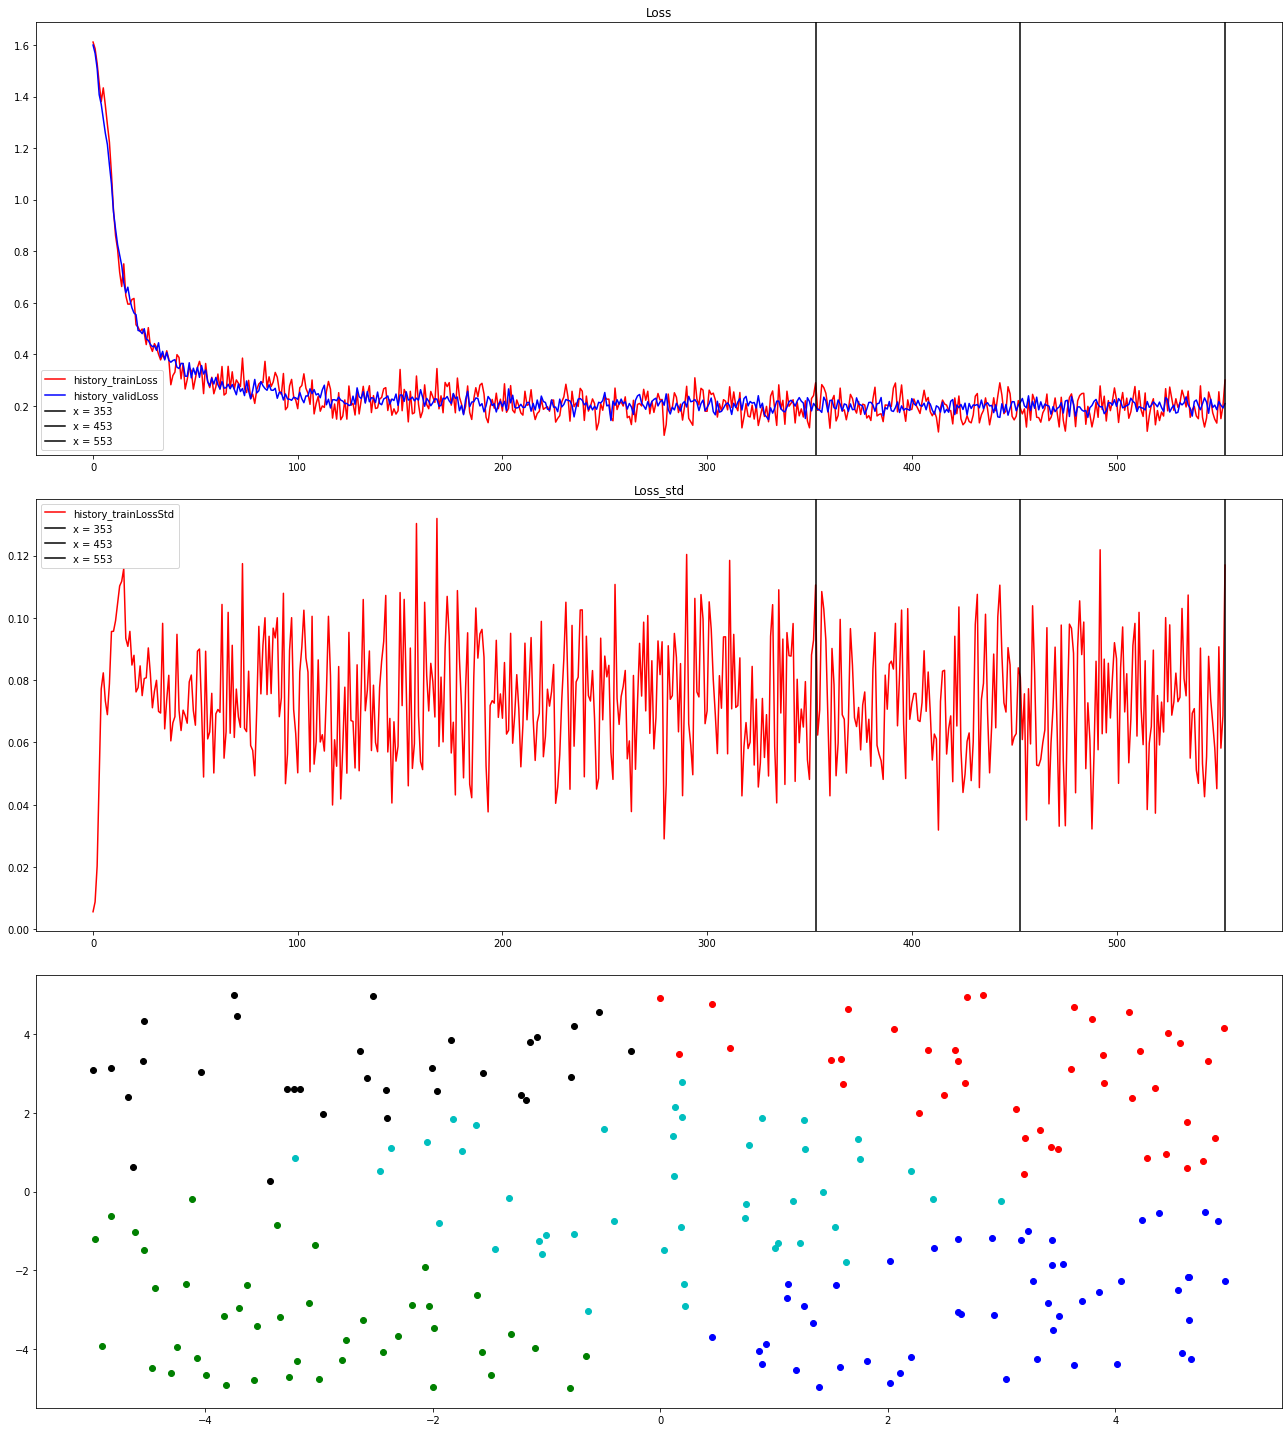

In [12]:
dataset_origin = DataGenerator([0, 0], 10, 300)
dataset_batched = dataset_origin.shuffle(300, reshuffle_each_iteration=True).batch(10, drop_remainder=True)
numberOfData = dataset_batched.cardinality().numpy()
#numberOfData = dataset_batched.cardinality().numpy()
trainDataset = dataset_batched.take(int(numberOfData * 0.3))
validDataset = dataset_batched.skip(int(numberOfData * 0.3))


model2 = CustomModel([3])

# Instantiate an optimizer to train the model.
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Prepare the metrics.
train_acc_metric = keras.metrics.Accuracy()
train_loss_metric = keras.metrics.SparseCategoricalCrossentropy()
val_loss_metric = keras.metrics.SparseCategoricalCrossentropy()

history_trainLoss = []
history_validLoss = []
history_trainLossStd = []

point = []
num_epochs = 10000 
patience = 100
stopped_epoch = 0
best_weights = None
best = np.Inf
wait = 0

numberOfStep = float(trainDataset.cardinality().numpy())

for epoch in range(num_epochs):
    start_time = time.time()
    loss_std_sum = 0.0
    clear_output(wait=True)
    for step, (input__, output__) in enumerate(trainDataset):
        with tf.GradientTape() as tape:
            predicts = model2(input__)
            true = tf.one_hot(output__.numpy(), depth=5)
            loss_mean, loss_std = CustomLosses(true, predicts)
            
            loss_std_sum+=loss_std
            
        grads = tape.gradient(loss_mean, model2.trainable_weights)
        optimizer.apply_gradients(zip(grads, model2.trainable_weights))
        
        # Update training metric.
        train_acc_metric.update_state(output__, tf.argmax(predicts, axis=1))
        train_loss_metric.update_state(output__, predicts)
        
        
        # Log every 200 batches.
        """
        if step % 5 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_mean))
            )
            print("Seen so far: %d samples" % ((step + 1) * 10))
        """
    
    print("epoch: %d   learning rate: %d" %(epoch, -kb.log(learning_rate) / kb.log(10.0) ))
    
    # history_trainLossStd
    history_trainLossStd.append(float(loss_std_sum / numberOfStep))
    
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    train_loss = train_loss_metric.result()
    history_trainLoss.append(float(train_loss))
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()
    
    #print("Training acc over epoch: %.4f" % (float(train_acc),))
    #print("Time taken: %.2fs" % (time.time() - start_time))
    print("Time taken: %.2fs, Training acc over epoch: %.4f" % ((time.time() - start_time), float(train_acc)))
    
    for input__, output__ in validDataset:
        predicts = model2(input__)
        # Update val metrics
        val_loss_metric.update_state(output__, predicts)
    val_loss = val_loss_metric.result()
    history_validLoss.append(float(val_loss))
    val_loss_metric.reset_states()
    #print("Validation acc: %.4f" % (float(val_acc),))
    #print("Time taken: %.2fs" % (time.time() - start_time))
    #print("Time taken: %.2fs, Validation acc: %.4f\n" % ((time.time() - start_time), float(val_acc)))
    
    
    if np.less(float(val_loss), best):
        best = float(val_loss)
        best_weights = model2.get_weights()
        wait = 0
        print("Time taken: %.2fs, Validation loss: %.4f\n" % ((time.time() - start_time), float(val_loss)))
    else:
        wait +=1
        if wait >= patience:
            
            point.append(epoch)
            model2.set_weights(best_weights)
            
            learning_rate /= 10
            optimizer = tf.keras.optimizers.Adam(learning_rate)
            """
            stopped_epoch = epoch
            model.set_weights(best_weights)
            print("Time taken: %.2fs, Validation loss: %.4f\nEarly Stopped !" % ((time.time() - start_time), float(val_loss)))
            break
            """
            if learning_rate <= 1e-5:
                stopped_epoch = epoch
                print("Time taken: %.2fs, Validation loss: %.4f\nEarly Stopped !" % ((time.time() - start_time), float(val_loss)))
                break
            else:
                wait = 0
            
            
        else:
            print("Time taken: %.2fs, Validation loss: %.4f\n" % ((time.time() - start_time), float(val_loss)))

drawGraph(validDataset, model2, history_trainLoss, history_validLoss, history_trainLossStd, point)

epoch: 846   learning rate: 4
Time taken: 0.05s, Training acc over epoch: 0.8667
Time taken: 0.09s, Validation loss: 0.2998
Early Stopped !


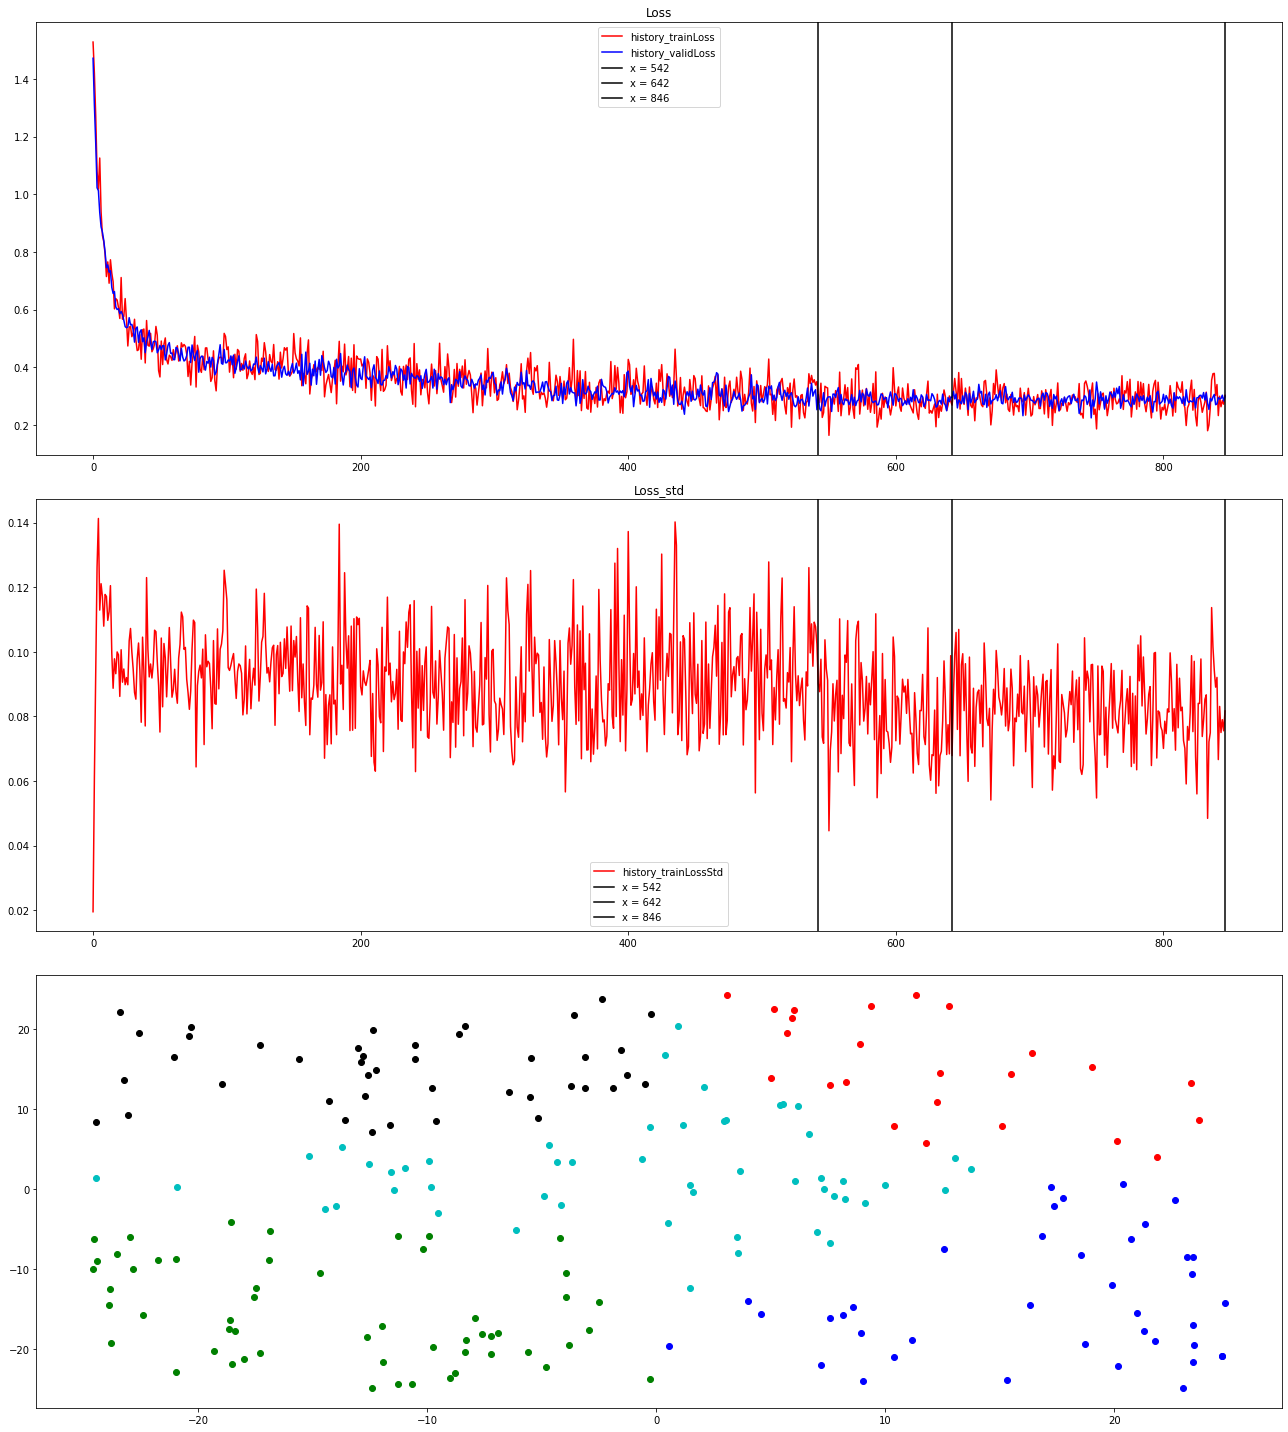

In [13]:
dataset_origin = DataGenerator([0, 0], 50, 300)
dataset_batched = dataset_origin.shuffle(300, reshuffle_each_iteration=True).batch(10, drop_remainder=True)
numberOfData = dataset_batched.cardinality().numpy()
#numberOfData = dataset_batched.cardinality().numpy()
trainDataset = dataset_batched.take(int(numberOfData * 0.3))
validDataset = dataset_batched.skip(int(numberOfData * 0.3))


model3 = CustomModel([3])

# Instantiate an optimizer to train the model.
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Prepare the metrics.
train_acc_metric = keras.metrics.Accuracy()
train_loss_metric = keras.metrics.SparseCategoricalCrossentropy()
val_loss_metric = keras.metrics.SparseCategoricalCrossentropy()

history_trainLoss = []
history_validLoss = []
history_trainLossStd = []

point = []
num_epochs = 10000 
patience = 100
stopped_epoch = 0
best_weights = None
best = np.Inf
wait = 0

numberOfStep = float(trainDataset.cardinality().numpy())

for epoch in range(num_epochs):
    start_time = time.time()
    loss_std_sum = 0.0
    clear_output(wait=True)
    for step, (input__, output__) in enumerate(trainDataset):
        with tf.GradientTape() as tape:
            predicts = model3(input__)
            true = tf.one_hot(output__.numpy(), depth=5)
            loss_mean, loss_std = CustomLosses(true, predicts)
            
            loss_std_sum+=loss_std
            
        grads = tape.gradient(loss_mean, model3.trainable_weights)
        optimizer.apply_gradients(zip(grads, model3.trainable_weights))
        
        # Update training metric.
        train_acc_metric.update_state(output__, tf.argmax(predicts, axis=1))
        train_loss_metric.update_state(output__, predicts)
        
        
        # Log every 200 batches.
        """
        if step % 5 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_mean))
            )
            print("Seen so far: %d samples" % ((step + 1) * 10))
        """
    
    print("epoch: %d   learning rate: %d" %(epoch, -kb.log(learning_rate) / kb.log(10.0) ))
    
    # history_trainLossStd
    history_trainLossStd.append(float(loss_std_sum / numberOfStep))
    
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    train_loss = train_loss_metric.result()
    history_trainLoss.append(float(train_loss))
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()
    
    #print("Training acc over epoch: %.4f" % (float(train_acc),))
    #print("Time taken: %.2fs" % (time.time() - start_time))
    print("Time taken: %.2fs, Training acc over epoch: %.4f" % ((time.time() - start_time), float(train_acc)))
    
    for input__, output__ in validDataset:
        predicts = model3(input__)
        # Update val metrics
        val_loss_metric.update_state(output__, predicts)
    val_loss = val_loss_metric.result()
    history_validLoss.append(float(val_loss))
    val_loss_metric.reset_states()
    #print("Validation acc: %.4f" % (float(val_acc),))
    #print("Time taken: %.2fs" % (time.time() - start_time))
    #print("Time taken: %.2fs, Validation acc: %.4f\n" % ((time.time() - start_time), float(val_acc)))
    
    
    if np.less(float(val_loss), best):
        best = float(val_loss)
        best_weights = model3.get_weights()
        wait = 0
        print("Time taken: %.2fs, Validation loss: %.4f\n" % ((time.time() - start_time), float(val_loss)))
    else:
        wait +=1
        if wait >= patience:
            
            point.append(epoch)
            model3.set_weights(best_weights)
            
            learning_rate /= 10
            optimizer = tf.keras.optimizers.Adam(learning_rate)
            """
            stopped_epoch = epoch
            model.set_weights(best_weights)
            print("Time taken: %.2fs, Validation loss: %.4f\nEarly Stopped !" % ((time.time() - start_time), float(val_loss)))
            break
            """
            if learning_rate <= 1e-5:
                stopped_epoch = epoch
                print("Time taken: %.2fs, Validation loss: %.4f\nEarly Stopped !" % ((time.time() - start_time), float(val_loss)))
                break
            else:
                wait = 0
            
            
        else:
            print("Time taken: %.2fs, Validation loss: %.4f\n" % ((time.time() - start_time), float(val_loss)))

drawGraph(validDataset, model3, history_trainLoss, history_validLoss, history_trainLossStd, point)

100%|██████████| 10000/10000 [01:52<00:00, 89.01it/s]


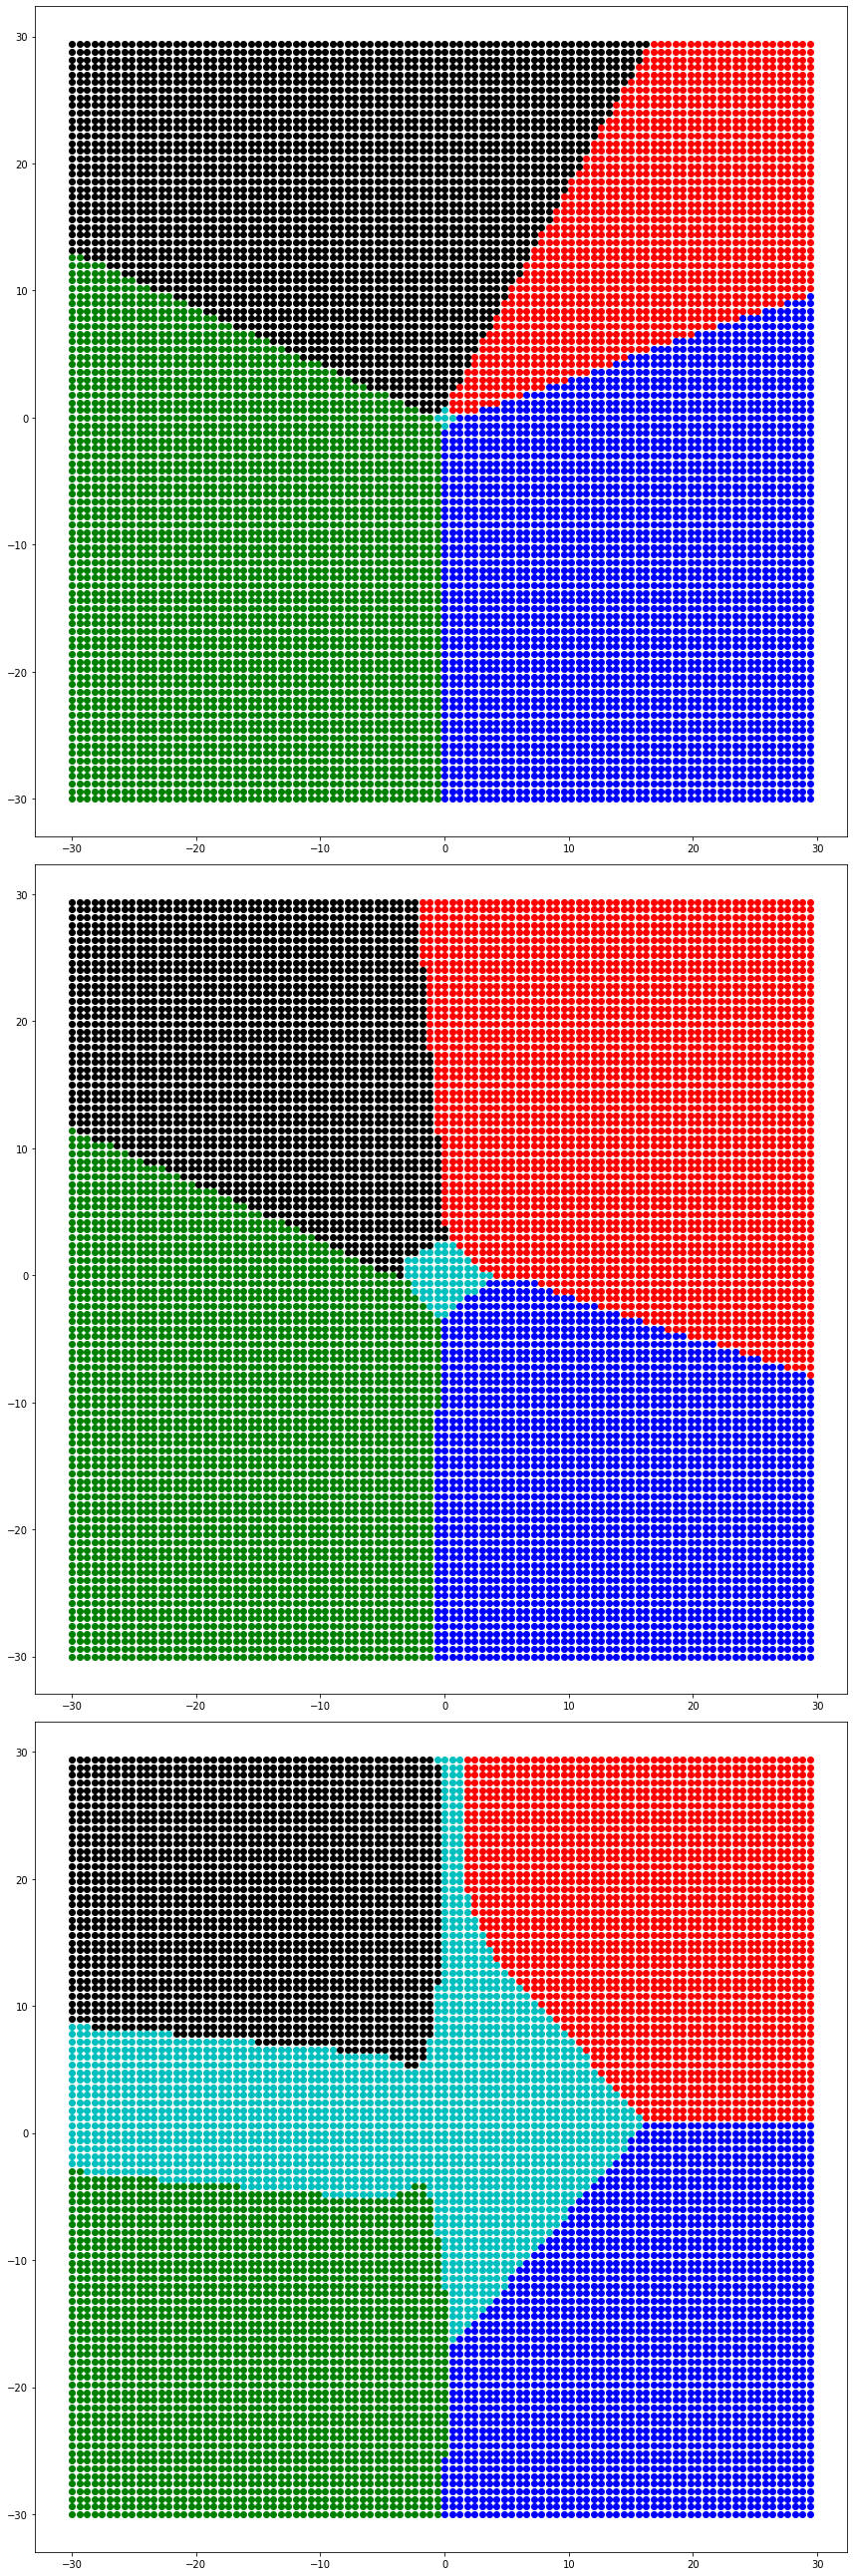

In [14]:
## Test Dataset
axisLength = 100
testInput = np.zeros([1, axisLength * axisLength, 2])
for i in range(axisLength):
    for j in range(axisLength):
        testInput[0, axisLength * i + j, 0] = (60.0 / axisLength)*i - 30
        testInput[0, axisLength * i + j, 1] = (60.0 / axisLength)*j - 30


fig, ax = plt.subplots(3, figsize=(12,36))
for input__ in testInput:
    predicts = model1(input__)
    index = tf.argmax(predicts, axis=1)
    for idx in tqdm(range(len(index))):
        point = testInput[0][idx]
        answer = int(index[idx])
        
        if answer == 0:
            ax[0].scatter(point[0], point[1], c='r')
        elif answer == 1:
            ax[0].scatter(point[0], point[1], c='b')
        elif answer == 2:
            ax[0].scatter(point[0], point[1], c='g')
        elif answer == 3:
            ax[0].scatter(point[0], point[1], c='k')
        elif answer == 4:
            ax[0].scatter(point[0], point[1], c='c')
            
    predicts = model2(input__)
    index = tf.argmax(predicts, axis=1)
    for idx in tqdm(range(len(index))):
        point = testInput[0][idx]
        answer = int(index[idx])
        
        if answer == 0:
            ax[1].scatter(point[0], point[1], c='r')
        elif answer == 1:
            ax[1].scatter(point[0], point[1], c='b')
        elif answer == 2:
            ax[1].scatter(point[0], point[1], c='g')
        elif answer == 3:
            ax[1].scatter(point[0], point[1], c='k')
        elif answer == 4:
            ax[1].scatter(point[0], point[1], c='c')
            
            
    predicts = model3(input__)
    index = tf.argmax(predicts, axis=1)
    for idx in tqdm(range(len(index))):
        point = testInput[0][idx]
        answer = int(index[idx])
        
        if answer == 0:
            ax[2].scatter(point[0], point[1], c='r')
        elif answer == 1:
            ax[2].scatter(point[0], point[1], c='b')
        elif answer == 2:
            ax[2].scatter(point[0], point[1], c='g')
        elif answer == 3:
            ax[2].scatter(point[0], point[1], c='k')
        elif answer == 4:
            ax[2].scatter(point[0], point[1], c='c')
fig.tight_layout()
plt.show()
#plt.savefig('3_gridTest.png')  
        
    

In [ ]:
for i in range(10):
    clear_output(wait=True)
    time.sleep(1)
    print('%d\n%d' %(i, 2*i))
    

In [ ]:
for layer in model.layers:
    print(layer.get_weights()[1])

In [ ]:
tmp = 1e-2
print(-kb.log(tmp) / kb.log(10.0))
#print("learning rate: %f" %())